# Homework 5
## Kozubek Hubert

### Importing libraries

In [33]:
import pandas as pd
import pickle as pkl
import numpy as np
import dalex as dx
from math import pi
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [34]:
random.seed(123)

### Data preprocessing

In [35]:
df = pd.read_csv('../EPL_2021.csv')

In [36]:
df = df[df['result'] !=  'OwnGoal']
df['result'] = [1 if a == 'Goal' else 0 for a in df['result']]

In [37]:
df = df.assign(distanceToGoal = ((105 - (df['X'] * 105)) ** 2 + (32.5 - (df['Y'] * 68)) ** 2) ** 0.5)
df = df.assign(angleToGoal = np.abs(np.arctan((7.32 * (105 - (df['X'] * 105))) / ((105 - (df['X'] * 105))**2 + (32.5 - (df['Y'] * 68)) ** 2 - (7.32 / 2) ** 2)) * 180 / pi))
df = df[['result', 'h_a', 'situation', 'shotType', 'lastAction', 'minute', 'distanceToGoal', 'angleToGoal']]

In [38]:
label_encoder = LabelEncoder()
categorical_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
changed_from =[]
changed_to = []
for feature in categorical_features:
    print(feature, list(df[feature].unique()), list(label_encoder.fit_transform(df[feature].unique())), "\n")
    changed_from.append(list(df[feature].unique()))
    changed_to.append(list(label_encoder.fit_transform(df[feature].unique())))
for feature in categorical_features:
    df[feature]=label_encoder.fit_transform(df[feature])

h_a ['h', 'a'] [1, 0] 

situation ['OpenPlay', 'FromCorner', 'DirectFreekick', 'SetPiece', 'Penalty'] [2, 1, 0, 4, 3] 

shotType ['Head', 'RightFoot', 'LeftFoot', 'OtherBodyPart'] [0, 3, 1, 2] 

lastAction ['Aerial', 'Throughball', 'BallRecovery', 'Pass', 'Chipped', 'Cross', 'BallTouch', 'Standard', 'None', 'TakeOn', 'HeadPass', 'Rebound', 'LayOff', 'Dispossessed', 'Goal', 'Tackle', 'Foul', 'End', 'CornerAwarded', 'BlockedPass', 'SubstitutionOn', 'KeeperPickup', 'Interception', 'OffsidePass', 'Clearance', 'Card', 'Challenge'] [0, 26, 1, 20, 6, 9, 2, 22, 18, 25, 14, 21, 17, 10, 13, 24, 12, 11, 8, 3, 23, 16, 15, 19, 7, 4, 5] 



In [39]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('result', axis=1),df['result'],test_size=0.2)

### Training Model

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

#### XGBoost

In [41]:
xgb = GradientBoostingClassifier()
xgb.fit(X_train, y_train)
print (f'XGBoost score: {xgb.score(X_test, y_test)*100:.2f}%')

XGBoost score: 89.61%


In [42]:
import dalex as dx
gb_exp = dx.Explainer(xgb, X_train, y_train, label = "Gradient Boosting Classifier")

Preparation of a new explainer is initiated

  -> data              : 5888 rows 7 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5888 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : Gradient Boosting Classifier
  -> predict function  : <function yhat_proba_default at 0x0000027917BB8550> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00963, mean = 0.105, max = 0.946
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.842, mean = -7.72e-05, max = 0.982
  -> model_info        : package sklearn

A new explainer has been created!


In [43]:
pdp = gb_exp.model_profile(type="partial")
ale = gb_exp.model_profile(type="accumulated")
pdp.result["_label_"] = "PDP profiles"
ale.result["_label_"] = "ALE profiles"

Calculating accumulated dependency: 100%|██████████| 7/7 [00:00<00:00, 10.14it/s]


In [44]:
p1 = Image(filename='P1.png')
p2 = Image(filename='P2.png')
p3 = Image(filename='P3.png') 

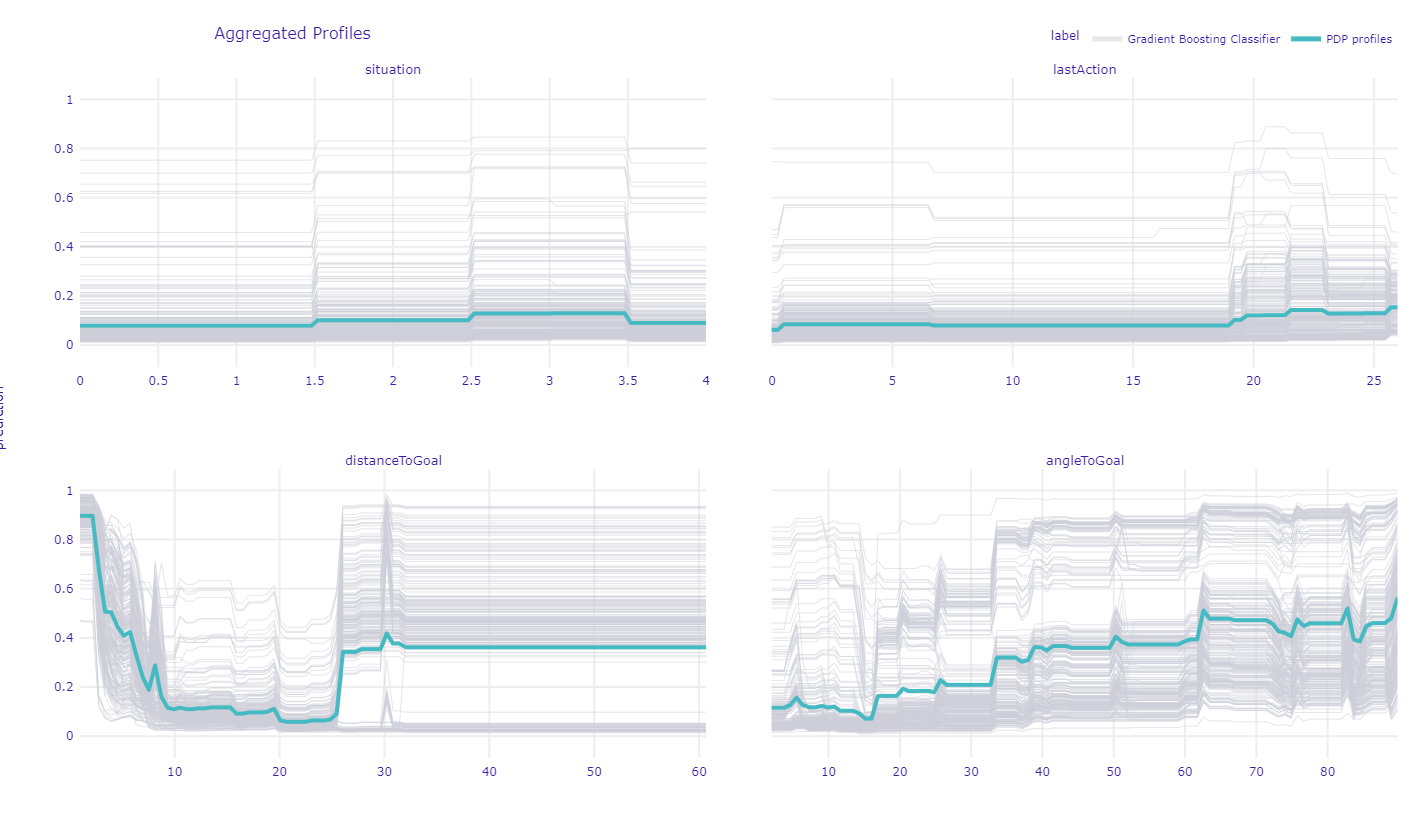

In [45]:
# pdp.plot(
#     geom="profiles",
#     variables=["situation", "lastAction", "distanceToGoal", "angleToGoal"],
# )
display(p1)

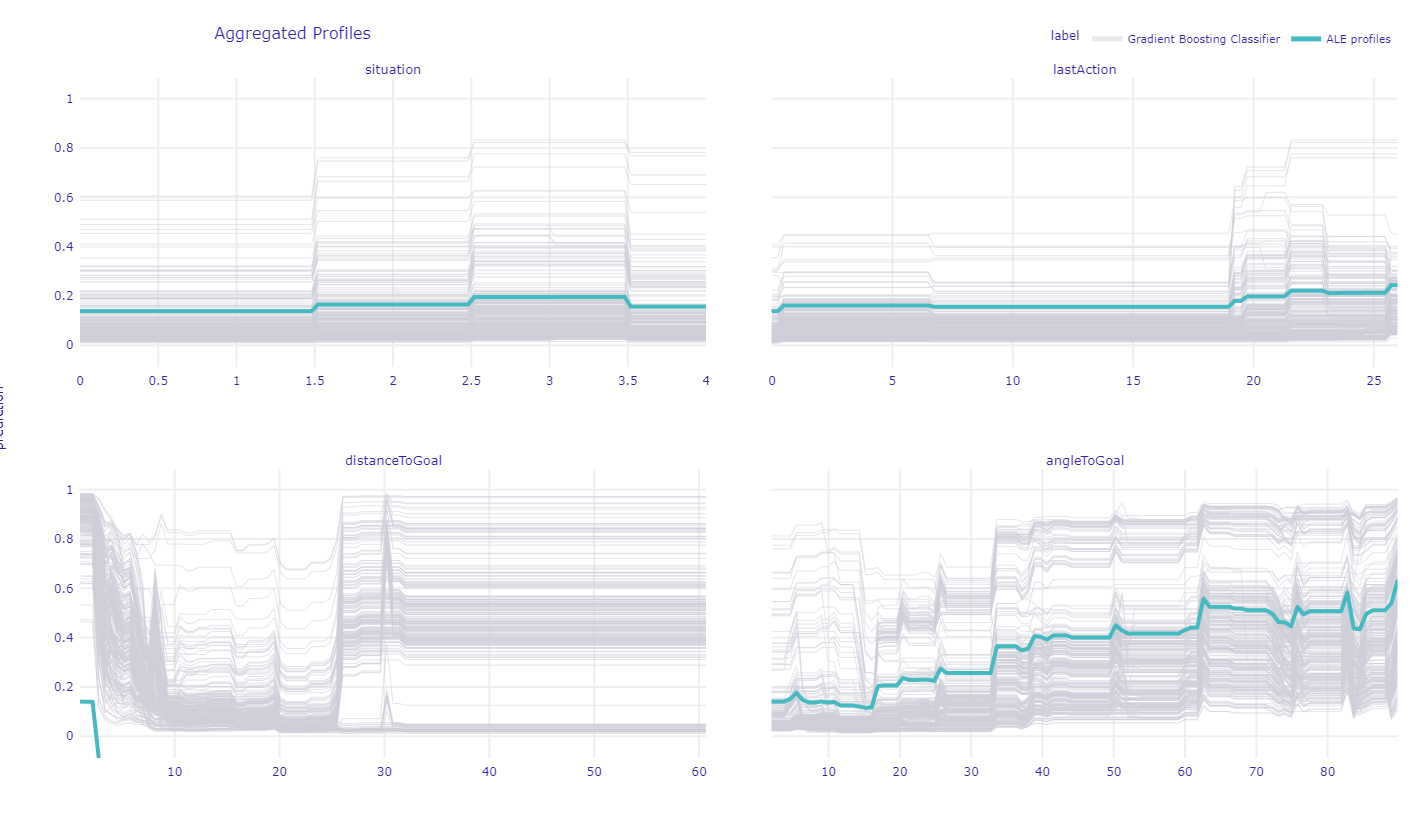

In [46]:
# ale.plot(
#     geom="profiles",
#     variables=["situation", "lastAction", "distanceToGoal", "angleToGoal"],
# )
display(p2)

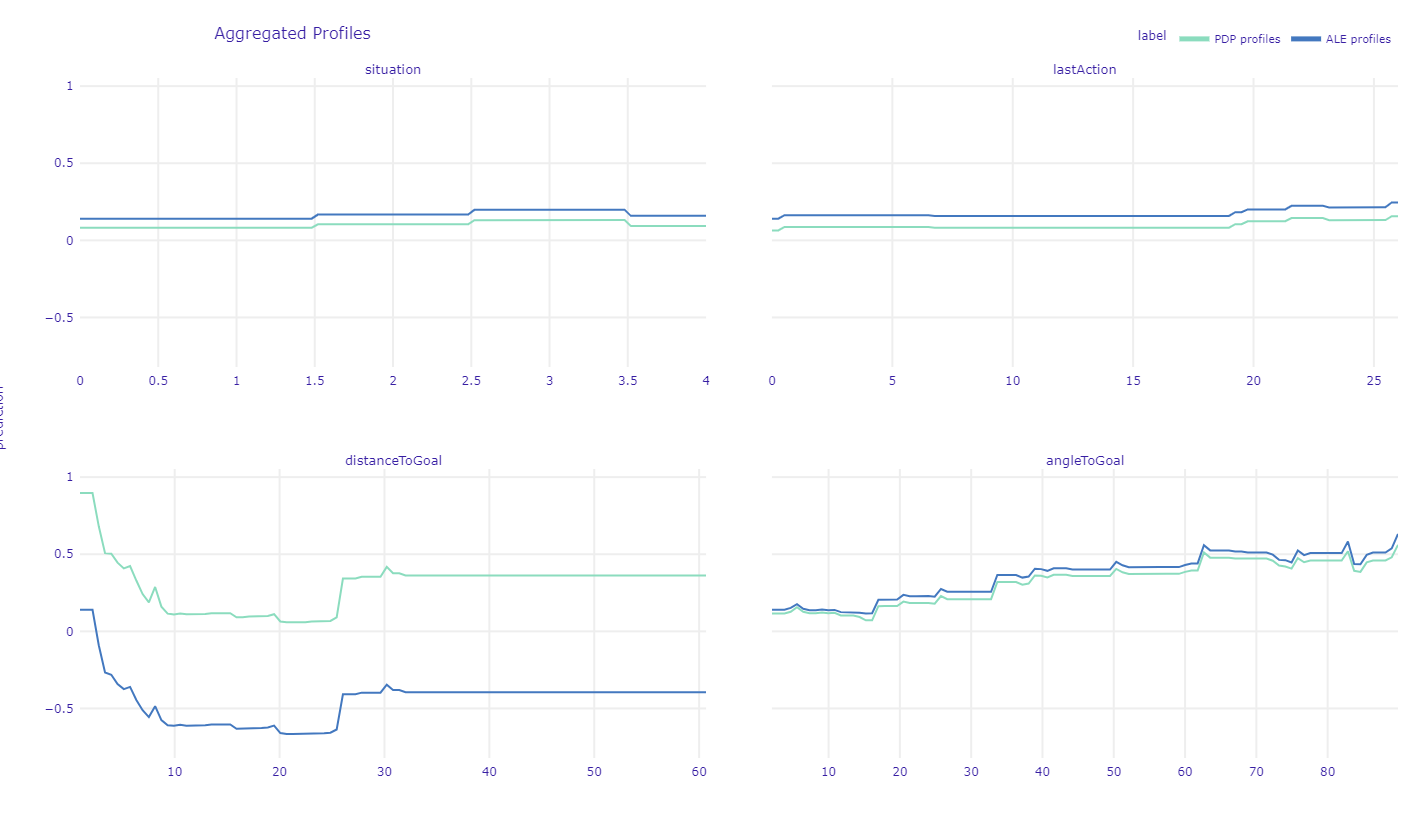

In [47]:
# pdp.plot(
#     ale, variables=["situation", "lastAction", "distanceToGoal", "angleToGoal"]
# )
display(p3)

### Summary

Looking at PDP we can see that lines are mainly parallel. It means that there are hardly any interactions between variables. It also shows us how quickly probability of scoring a goal drops with the distance to the goal. ALE profiles also seem to confirm what we already know from PDP. In the picture comparing PDP and ALE we can see that the profiles are parallel to each other. The biggest difference between PDP and ALE is seen in 'angle to goal' variable, however it is really small and not clear why this is the case.